In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""
test=""
z_diff=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "uber"
z_range = "all_z"
key = ""
quantile = ""
test = "foreground"
z_diff = 0.5


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
z_diff=float(z_diff)

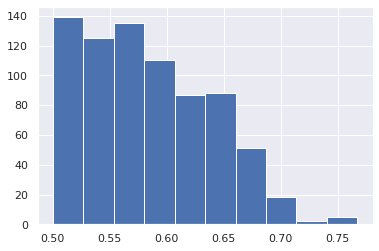

In [5]:
if test=="foreground":
    members=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])>=z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
    
elif test=="background":
    members=background=shapes[(shapes[('All','Z')]-shapes[('All','ZRED2')])<=-z_diff]
    diff=members[('All','Z')]-members[('All','ZRED2')]
    diff.hist()
    diff.describe()
elif test=="":
    members=shapes
else:
    raise TypeError

In [6]:
if vol!="uber":
    members=shapes

In [7]:
if quantile!="":
    i=int(quantile)

In [8]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [9]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [10]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [11]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [12]:
NBINS=10

In [13]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [14]:
len(shapes)

1079244

In [15]:
len(members)

760

In [16]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [17]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=members[members['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [18]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [19]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [20]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

6it [00:00, 57.97it/s]

18it [00:00, 67.88it/s]

30it [00:00, 77.13it/s]

42it [00:00, 85.49it/s]

54it [00:00, 92.29it/s]

66it [00:00, 98.01it/s]

78it [00:00, 102.26it/s]

90it [00:00, 106.00it/s]

102it [00:00, 108.64it/s]

114it [00:01, 110.11it/s]

126it [00:01, 111.00it/s]

138it [00:01, 111.38it/s]

150it [00:01, 112.05it/s]

162it [00:01, 113.03it/s]

174it [00:01, 111.88it/s]

186it [00:01, 103.57it/s]

198it [00:01, 106.25it/s]

210it [00:01, 108.32it/s]

222it [00:02, 110.16it/s]

234it [00:02, 109.53it/s]

246it [00:02, 110.29it/s]

258it [00:02, 111.94it/s]

270it [00:02, 113.18it/s]

282it [00:02, 113.99it/s]

294it [00:02, 114.41it/s]

306it [00:02, 114.74it/s]

318it [00:02, 115.05it/s]

330it [00:02, 115.17it/s]

342it [00:03, 115.10it/s]

354it [00:03, 114.84it/s]

366it [00:03, 115.05it/s]

378it [00:03, 114.27it/s]

390it [00:03, 113.25it/s]

402it [00:03, 113.44it/s]

414it [00:03, 113.89it/s]

426it [00:03, 114.40it/s]

438it [00:03, 114.46it/s]

450it [00:04, 114.56it/s]

462it [00:04, 114.51it/s]

474it [00:04, 111.90it/s]

486it [00:04, 112.76it/s]

498it [00:04, 112.89it/s]

510it [00:04, 112.93it/s]

522it [00:04, 113.16it/s]

534it [00:04, 113.53it/s]

546it [00:04, 113.84it/s]

558it [00:04, 114.45it/s]

570it [00:05, 114.83it/s]

582it [00:05, 114.80it/s]

594it [00:05, 114.66it/s]

606it [00:05, 115.04it/s]

618it [00:05, 114.99it/s]

630it [00:05, 114.80it/s]

642it [00:05, 114.96it/s]

654it [00:05, 114.65it/s]

666it [00:05, 114.56it/s]

678it [00:06, 114.93it/s]

690it [00:06, 114.91it/s]

702it [00:06, 114.96it/s]

714it [00:06, 115.28it/s]

726it [00:06, 115.67it/s]

738it [00:06, 116.17it/s]

750it [00:06, 116.93it/s]

762it [00:06, 115.68it/s]

774it [00:06, 114.72it/s]

786it [00:06, 114.22it/s]

798it [00:07, 114.64it/s]

810it [00:07, 114.86it/s]

822it [00:07, 114.67it/s]

834it [00:07, 114.73it/s]

846it [00:07, 114.76it/s]

858it [00:07, 114.56it/s]

870it [00:07, 114.85it/s]

882it [00:07, 114.55it/s]

894it [00:07, 114.89it/s]

906it [00:08, 115.50it/s]

918it [00:08, 115.47it/s]

930it [00:08, 114.57it/s]

942it [00:08, 114.38it/s]

954it [00:08, 114.68it/s]

966it [00:08, 114.72it/s]

978it [00:08, 114.06it/s]

990it [00:08, 112.51it/s]

1002it [00:08, 112.14it/s]

1014it [00:08, 112.88it/s]

1026it [00:09, 113.17it/s]

1038it [00:09, 113.65it/s]

1050it [00:09, 113.73it/s]

1062it [00:09, 113.98it/s]

1074it [00:09, 114.30it/s]

1086it [00:09, 114.42it/s]

1098it [00:09, 114.39it/s]

1110it [00:09, 114.77it/s]

1122it [00:09, 114.19it/s]

1134it [00:10, 114.54it/s]

1146it [00:10, 114.42it/s]

1158it [00:10, 114.61it/s]

1170it [00:10, 114.55it/s]

1182it [00:10, 114.50it/s]

1194it [00:10, 114.48it/s]

1206it [00:10, 114.26it/s]

1218it [00:10, 114.19it/s]

1230it [00:10, 114.29it/s]

1242it [00:10, 114.35it/s]

1254it [00:11, 114.00it/s]

1266it [00:11, 114.26it/s]

1278it [00:11, 114.59it/s]

1290it [00:11, 114.98it/s]

1302it [00:11, 115.06it/s]

1314it [00:11, 114.93it/s]

1326it [00:11, 114.92it/s]

1338it [00:11, 114.88it/s]

1350it [00:11, 115.44it/s]

1362it [00:11, 115.15it/s]

1374it [00:12, 115.28it/s]

1386it [00:12, 114.99it/s]

1398it [00:12, 115.15it/s]

1410it [00:12, 115.56it/s]

1422it [00:12, 114.57it/s]

1434it [00:12, 114.97it/s]

1446it [00:12, 114.95it/s]

1458it [00:12, 114.55it/s]

1470it [00:12, 113.74it/s]

1482it [00:13, 113.55it/s]

1494it [00:13, 113.90it/s]

1506it [00:13, 114.49it/s]

1518it [00:13, 115.08it/s]

1530it [00:13, 114.86it/s]

1542it [00:13, 114.68it/s]

1554it [00:13, 114.66it/s]

1566it [00:13, 115.21it/s]

1578it [00:13, 115.15it/s]

1590it [00:13, 115.10it/s]

1602it [00:14, 115.25it/s]

1614it [00:14, 115.05it/s]

1626it [00:14, 114.55it/s]

1638it [00:14, 114.00it/s]

1650it [00:14, 112.15it/s]

1662it [00:14, 112.56it/s]

1674it [00:14, 113.54it/s]

1686it [00:14, 113.99it/s]

1698it [00:14, 114.10it/s]

1710it [00:15, 114.52it/s]

1722it [00:15, 114.44it/s]

1734it [00:15, 114.22it/s]

1746it [00:15, 113.89it/s]

1758it [00:15, 113.91it/s]

1770it [00:15, 113.79it/s]

1782it [00:15, 113.53it/s]

1794it [00:15, 114.03it/s]

1806it [00:15, 110.22it/s]

1818it [00:16, 101.01it/s]

1829it [00:16, 101.46it/s]

1841it [00:16, 104.98it/s]

1853it [00:16, 107.96it/s]

1865it [00:16, 109.87it/s]

1877it [00:16, 111.21it/s]

1889it [00:16, 113.07it/s]

1901it [00:16, 113.28it/s]

1913it [00:16, 113.60it/s]

1925it [00:16, 114.25it/s]

1937it [00:17, 113.21it/s]

1949it [00:17, 113.29it/s]

1961it [00:17, 113.46it/s]

1973it [00:17, 112.97it/s]

1985it [00:17, 113.44it/s]

1997it [00:17, 113.84it/s]

2009it [00:17, 114.07it/s]

2021it [00:17, 114.30it/s]

2033it [00:17, 114.38it/s]

2045it [00:18, 113.91it/s]

2057it [00:18, 114.49it/s]

2069it [00:18, 115.59it/s]

2081it [00:18, 116.57it/s]

2093it [00:18, 117.08it/s]

2105it [00:18, 115.91it/s]

2117it [00:18, 116.05it/s]

2129it [00:18, 115.95it/s]

2141it [00:18, 115.75it/s]

2153it [00:18, 115.79it/s]

2165it [00:19, 115.76it/s]

2177it [00:19, 115.82it/s]

2189it [00:19, 115.38it/s]

2201it [00:19, 115.28it/s]

2213it [00:19, 115.17it/s]

2225it [00:19, 115.56it/s]

2237it [00:19, 114.94it/s]

2249it [00:19, 115.18it/s]

2261it [00:19, 115.04it/s]

2273it [00:20, 114.99it/s]

2285it [00:20, 114.45it/s]

2297it [00:20, 113.83it/s]

2309it [00:20, 113.65it/s]

2321it [00:20, 113.62it/s]

2333it [00:20, 113.57it/s]

2345it [00:20, 113.91it/s]

2357it [00:20, 114.24it/s]

2369it [00:20, 114.45it/s]

2381it [00:20, 114.11it/s]

2393it [00:21, 114.44it/s]

2405it [00:21, 114.51it/s]

2417it [00:21, 115.08it/s]

2429it [00:21, 114.91it/s]

2441it [00:21, 115.35it/s]

2453it [00:21, 115.46it/s]

2465it [00:21, 115.16it/s]

2477it [00:21, 115.23it/s]

2489it [00:21, 114.98it/s]

2501it [00:21, 115.16it/s]

2513it [00:22, 114.20it/s]

2525it [00:22, 114.43it/s]

2537it [00:22, 114.43it/s]

2549it [00:22, 114.80it/s]

2561it [00:22, 114.12it/s]

2573it [00:22, 110.81it/s]

2585it [00:22, 111.14it/s]

2597it [00:22, 109.48it/s]

2609it [00:22, 110.94it/s]

2621it [00:23, 104.23it/s]

2633it [00:23, 106.90it/s]

2644it [00:23, 107.59it/s]

2656it [00:23, 109.07it/s]

2668it [00:23, 110.90it/s]

2680it [00:23, 111.09it/s]

2692it [00:23, 111.47it/s]

2704it [00:23, 110.87it/s]

2716it [00:23, 111.56it/s]

2728it [00:24, 111.90it/s]

2740it [00:24, 111.48it/s]

2752it [00:24, 112.08it/s]

2764it [00:24, 112.05it/s]

2776it [00:24, 112.16it/s]

2788it [00:24, 112.12it/s]

2800it [00:24, 112.61it/s]

2812it [00:24, 112.84it/s]

2824it [00:24, 112.99it/s]

2836it [00:25, 112.93it/s]

2848it [00:25, 113.19it/s]

2860it [00:25, 113.09it/s]

2872it [00:25, 113.17it/s]

2884it [00:25, 113.72it/s]

2896it [00:25, 113.56it/s]

2908it [00:25, 113.84it/s]

2920it [00:25, 113.78it/s]

2932it [00:25, 113.60it/s]

2944it [00:25, 111.22it/s]

2956it [00:26, 111.77it/s]

2968it [00:26, 112.17it/s]

2980it [00:26, 112.39it/s]

2992it [00:26, 113.09it/s]

3004it [00:26, 112.65it/s]

3016it [00:26, 112.45it/s]

3028it [00:26, 112.68it/s]

3040it [00:26, 112.91it/s]

3052it [00:26, 111.89it/s]

3064it [00:27, 112.64it/s]

3076it [00:27, 113.29it/s]

3088it [00:27, 113.83it/s]

3100it [00:27, 114.06it/s]

3112it [00:27, 114.25it/s]

3124it [00:27, 114.90it/s]

3136it [00:27, 113.87it/s]

3148it [00:27, 113.39it/s]

3160it [00:27, 112.88it/s]

3172it [00:27, 112.87it/s]

3184it [00:28, 113.73it/s]

3196it [00:28, 113.73it/s]

3208it [00:28, 113.89it/s]

3220it [00:28, 113.43it/s]

3232it [00:28, 113.30it/s]

3244it [00:28, 113.63it/s]

3256it [00:28, 113.60it/s]

3268it [00:28, 113.98it/s]

3280it [00:28, 113.98it/s]

3292it [00:29, 113.85it/s]

3304it [00:29, 113.07it/s]

3316it [00:29, 113.09it/s]

3328it [00:29, 113.31it/s]

3340it [00:29, 113.04it/s]

3352it [00:29, 112.42it/s]

3364it [00:29, 112.19it/s]

3376it [00:29, 112.45it/s]

3388it [00:29, 113.03it/s]

3400it [00:29, 113.12it/s]

3412it [00:30, 113.44it/s]

3424it [00:30, 113.05it/s]

3436it [00:30, 112.92it/s]

3448it [00:30, 113.19it/s]

3460it [00:30, 113.25it/s]

3472it [00:30, 113.05it/s]

3484it [00:30, 112.92it/s]

3496it [00:30, 112.84it/s]

3508it [00:30, 113.14it/s]

3520it [00:31, 113.58it/s]

3532it [00:31, 113.23it/s]

3544it [00:31, 113.25it/s]

3556it [00:31, 113.35it/s]

3568it [00:31, 113.66it/s]

3580it [00:31, 113.75it/s]

3592it [00:31, 113.72it/s]

3604it [00:31, 113.12it/s]

3616it [00:31, 113.56it/s]

3628it [00:32, 113.10it/s]

3640it [00:32, 112.86it/s]

3652it [00:32, 112.21it/s]

3664it [00:32, 111.30it/s]

3676it [00:32, 111.96it/s]

3688it [00:32, 112.38it/s]

3700it [00:32, 111.73it/s]

3712it [00:32, 112.29it/s]

3724it [00:32, 112.07it/s]

3736it [00:32, 111.38it/s]

3748it [00:33, 102.03it/s]

3759it [00:33, 95.84it/s] 

3769it [00:33, 92.90it/s]

3780it [00:33, 96.64it/s]

3792it [00:33, 100.69it/s]

3804it [00:33, 103.89it/s]

3816it [00:33, 106.21it/s]

3827it [00:33, 105.03it/s]

3839it [00:33, 107.18it/s]

3851it [00:34, 108.60it/s]

3863it [00:34, 109.46it/s]

3875it [00:34, 110.22it/s]

3887it [00:34, 110.96it/s]

3899it [00:34, 111.78it/s]

3911it [00:34, 111.44it/s]

3923it [00:34, 112.02it/s]

3935it [00:34, 111.51it/s]

3947it [00:34, 111.84it/s]

3959it [00:35, 112.08it/s]

3971it [00:35, 112.30it/s]

3983it [00:35, 112.70it/s]

3995it [00:35, 112.79it/s]

4007it [00:35, 112.62it/s]

4019it [00:35, 109.31it/s]

4031it [00:35, 111.03it/s]

4043it [00:35, 112.30it/s]

4055it [00:35, 112.44it/s]

4067it [00:36, 112.34it/s]

4079it [00:36, 113.00it/s]

4091it [00:36, 113.67it/s]

4103it [00:36, 113.69it/s]

4115it [00:36, 113.83it/s]

4127it [00:36, 113.74it/s]

4139it [00:36, 113.80it/s]

4151it [00:36, 113.44it/s]

4163it [00:36, 112.95it/s]

4175it [00:36, 112.90it/s]

4187it [00:37, 112.49it/s]

4199it [00:37, 112.33it/s]

4211it [00:37, 112.25it/s]

4223it [00:37, 112.36it/s]

4235it [00:37, 112.53it/s]

4247it [00:37, 112.46it/s]

4259it [00:37, 111.69it/s]

4271it [00:37, 112.00it/s]

4283it [00:37, 111.98it/s]

4295it [00:38, 111.58it/s]

4307it [00:38, 112.24it/s]

4319it [00:38, 110.59it/s]

4331it [00:38, 112.05it/s]

4343it [00:38, 112.79it/s]

4355it [00:38, 113.47it/s]

4367it [00:38, 114.20it/s]

4379it [00:38, 114.84it/s]

4391it [00:38, 114.67it/s]

4403it [00:38, 114.73it/s]

4415it [00:39, 113.84it/s]

4427it [00:39, 113.11it/s]

4439it [00:39, 111.35it/s]

4451it [00:39, 112.06it/s]

4463it [00:39, 111.95it/s]

4475it [00:39, 111.64it/s]

4487it [00:39, 111.44it/s]

4499it [00:39, 110.95it/s]

4511it [00:39, 112.18it/s]

4523it [00:40, 113.24it/s]

4535it [00:40, 113.89it/s]

4547it [00:40, 114.03it/s]

4559it [00:40, 114.64it/s]

4571it [00:40, 115.11it/s]

4583it [00:40, 114.68it/s]

4595it [00:40, 115.33it/s]

4607it [00:40, 115.09it/s]

4619it [00:40, 115.07it/s]

4631it [00:41, 110.90it/s]

4643it [00:41, 112.24it/s]

4655it [00:41, 112.14it/s]

4667it [00:41, 110.43it/s]

4679it [00:41, 109.08it/s]

4691it [00:41, 111.17it/s]

4703it [00:41, 112.41it/s]

4715it [00:41, 112.94it/s]

4727it [00:41, 113.88it/s]

4739it [00:41, 114.44it/s]

4751it [00:42, 115.36it/s]

4763it [00:42, 114.36it/s]

4775it [00:42, 114.96it/s]

4787it [00:42, 116.20it/s]

4799it [00:42, 115.86it/s]

4811it [00:42, 116.29it/s]

4823it [00:42, 116.33it/s]

4835it [00:42, 113.14it/s]

4847it [00:42, 113.52it/s]

4859it [00:43, 114.83it/s]

4871it [00:43, 115.30it/s]

4883it [00:43, 115.77it/s]

4895it [00:43, 116.05it/s]

4907it [00:43, 116.22it/s]

4919it [00:43, 116.34it/s]

4931it [00:43, 115.87it/s]

4943it [00:43, 114.89it/s]

4955it [00:43, 114.77it/s]

4967it [00:43, 114.94it/s]

4979it [00:44, 115.39it/s]

4991it [00:44, 116.17it/s]

5003it [00:44, 116.25it/s]

5015it [00:44, 116.43it/s]

5027it [00:44, 116.66it/s]

5039it [00:44, 116.58it/s]

5051it [00:44, 116.84it/s]

5063it [00:44, 116.94it/s]

5075it [00:44, 116.67it/s]

5087it [00:44, 113.81it/s]

5099it [00:45, 113.46it/s]

5111it [00:45, 113.23it/s]

5123it [00:45, 112.17it/s]

5135it [00:45, 111.44it/s]

5147it [00:45, 113.39it/s]

5159it [00:45, 114.12it/s]

5171it [00:45, 115.10it/s]

5183it [00:45, 115.52it/s]

5195it [00:45, 115.77it/s]

5207it [00:46, 111.76it/s]

5219it [00:46, 112.35it/s]

5231it [00:46, 110.95it/s]

5243it [00:46, 112.48it/s]

5255it [00:46, 113.26it/s]

5267it [00:46, 114.32it/s]

5279it [00:46, 108.14it/s]

5291it [00:46, 109.82it/s]

5303it [00:46, 111.03it/s]

5315it [00:47, 111.78it/s]

5327it [00:47, 111.96it/s]

5339it [00:47, 112.90it/s]

5351it [00:47, 113.36it/s]

5363it [00:47, 114.13it/s]

5375it [00:47, 114.32it/s]

5387it [00:47, 115.28it/s]

5399it [00:47, 115.26it/s]

5411it [00:47, 115.15it/s]

5423it [00:47, 114.58it/s]

5435it [00:48, 114.73it/s]

5447it [00:48, 114.66it/s]

5459it [00:48, 114.79it/s]

5471it [00:48, 114.93it/s]

5483it [00:48, 114.05it/s]

5495it [00:48, 114.40it/s]

5507it [00:48, 114.23it/s]

5519it [00:48, 114.54it/s]

5531it [00:48, 114.99it/s]

5543it [00:49, 114.70it/s]

5555it [00:49, 114.27it/s]

5567it [00:49, 115.40it/s]

5579it [00:49, 115.01it/s]

5591it [00:49, 115.54it/s]

5603it [00:49, 115.71it/s]

5615it [00:49, 114.97it/s]

5627it [00:49, 114.85it/s]

5639it [00:49, 115.35it/s]

5651it [00:49, 115.72it/s]

5663it [00:50, 115.13it/s]

5675it [00:50, 115.75it/s]

5687it [00:50, 115.31it/s]

5699it [00:50, 115.28it/s]

5711it [00:50, 115.18it/s]

5723it [00:50, 115.05it/s]

5735it [00:50, 115.18it/s]

5747it [00:50, 115.25it/s]

5759it [00:50, 115.17it/s]

5771it [00:50, 115.33it/s]

5783it [00:51, 114.53it/s]

5795it [00:51, 114.53it/s]

5807it [00:51, 115.02it/s]

5819it [00:51, 115.20it/s]

5831it [00:51, 115.27it/s]

5843it [00:51, 115.12it/s]

5855it [00:51, 114.66it/s]

5867it [00:51, 114.49it/s]

5879it [00:51, 114.73it/s]

5891it [00:52, 114.90it/s]

5903it [00:52, 114.95it/s]

5915it [00:52, 114.99it/s]

5927it [00:52, 114.68it/s]

5939it [00:52, 115.20it/s]

5951it [00:52, 115.22it/s]

5963it [00:52, 115.15it/s]

5975it [00:52, 114.97it/s]

5987it [00:52, 115.17it/s]

5999it [00:52, 112.68it/s]

6011it [00:53, 113.25it/s]

6023it [00:53, 112.92it/s]

6035it [00:53, 113.07it/s]

6047it [00:53, 113.15it/s]

6059it [00:53, 113.34it/s]

6071it [00:53, 113.39it/s]

6083it [00:53, 113.67it/s]

6095it [00:53, 115.10it/s]

6107it [00:53, 115.01it/s]

6119it [00:54, 115.30it/s]

6131it [00:54, 114.82it/s]

6143it [00:54, 114.36it/s]

6155it [00:54, 115.37it/s]

6167it [00:54, 115.41it/s]

6179it [00:54, 115.55it/s]

6191it [00:54, 115.28it/s]

6203it [00:54, 115.33it/s]

6215it [00:54, 115.49it/s]

6227it [00:54, 114.79it/s]

6239it [00:55, 114.27it/s]

6251it [00:55, 114.87it/s]

6263it [00:55, 114.94it/s]

6275it [00:55, 115.24it/s]

6287it [00:55, 115.55it/s]

6299it [00:55, 115.41it/s]

6311it [00:55, 115.28it/s]

6323it [00:55, 115.67it/s]

6335it [00:55, 115.70it/s]

6347it [00:56, 114.76it/s]

6359it [00:56, 111.23it/s]

6371it [00:56, 111.92it/s]

6383it [00:56, 112.35it/s]

6395it [00:56, 112.43it/s]

6407it [00:56, 112.82it/s]

6419it [00:56, 112.92it/s]

6431it [00:56, 113.26it/s]

6443it [00:56, 113.12it/s]

6455it [00:56, 113.38it/s]

6467it [00:57, 113.59it/s]

6479it [00:57, 112.99it/s]

6491it [00:57, 112.91it/s]

6503it [00:57, 111.48it/s]

6515it [00:57, 112.24it/s]

6527it [00:57, 112.49it/s]

6539it [00:57, 113.12it/s]

6551it [00:57, 112.91it/s]

6563it [00:57, 113.32it/s]

6575it [00:58, 113.25it/s]

6587it [00:58, 113.46it/s]

6599it [00:58, 113.65it/s]

6611it [00:58, 113.57it/s]

6623it [00:58, 113.23it/s]

6635it [00:58, 113.19it/s]

6647it [00:58, 113.27it/s]

6659it [00:58, 113.69it/s]

6671it [00:58, 112.92it/s]

6683it [00:58, 112.71it/s]

6695it [00:59, 112.90it/s]

6707it [00:59, 112.68it/s]

6719it [00:59, 112.81it/s]

6731it [00:59, 113.20it/s]

6743it [00:59, 112.91it/s]

6755it [00:59, 113.28it/s]

6767it [00:59, 114.12it/s]

6779it [00:59, 114.25it/s]

6791it [00:59, 113.46it/s]

6803it [01:00, 113.95it/s]

6815it [01:00, 112.51it/s]

6827it [01:00, 114.19it/s]

6839it [01:00, 114.54it/s]

6851it [01:00, 115.48it/s]

6863it [01:00, 115.44it/s]

6875it [01:00, 115.24it/s]

6887it [01:00, 111.87it/s]

6899it [01:00, 113.12it/s]

6911it [01:00, 114.15it/s]

6923it [01:01, 115.32it/s]

6935it [01:01, 115.01it/s]

6947it [01:01, 115.28it/s]

6959it [01:01, 115.27it/s]

6971it [01:01, 115.78it/s]

6983it [01:01, 116.19it/s]

6995it [01:01, 116.08it/s]

7007it [01:01, 115.49it/s]

7019it [01:01, 115.31it/s]

7031it [01:02, 115.22it/s]

7043it [01:02, 104.85it/s]

7054it [01:02, 100.93it/s]

7065it [01:02, 96.50it/s] 

7075it [01:02, 93.40it/s]

7085it [01:02, 91.15it/s]

7095it [01:02, 89.48it/s]

7107it [01:02, 96.11it/s]

7119it [01:02, 101.71it/s]

7131it [01:03, 105.52it/s]

7143it [01:03, 109.05it/s]

7155it [01:03, 111.24it/s]

7167it [01:03, 112.94it/s]

7179it [01:03, 114.06it/s]

7191it [01:03, 113.95it/s]

7203it [01:03, 115.16it/s]

7215it [01:03, 108.77it/s]

7226it [01:03, 101.14it/s]

7237it [01:04, 95.86it/s] 

7247it [01:04, 93.58it/s]

7257it [01:04, 92.94it/s]

7269it [01:04, 98.18it/s]

7281it [01:04, 102.41it/s]

7293it [01:04, 106.07it/s]

7305it [01:04, 108.59it/s]

7317it [01:04, 110.31it/s]

7329it [01:04, 111.51it/s]

7341it [01:05, 112.83it/s]

7353it [01:05, 113.89it/s]

7365it [01:05, 114.72it/s]

7377it [01:05, 113.31it/s]

7389it [01:05, 104.21it/s]

7400it [01:05, 98.52it/s] 

7411it [01:05, 95.37it/s]

7421it [01:05, 92.92it/s]

7431it [01:05, 90.53it/s]

7441it [01:06, 89.14it/s]

7450it [01:06, 88.73it/s]

7459it [01:06, 88.21it/s]

7468it [01:06, 87.41it/s]

7477it [01:06, 87.54it/s]

7487it [01:06, 90.78it/s]

7499it [01:06, 96.95it/s]

7511it [01:06, 101.80it/s]

7523it [01:06, 105.52it/s]

7535it [01:06, 108.70it/s]

7547it [01:07, 110.38it/s]

7559it [01:07, 111.75it/s]

7571it [01:07, 112.93it/s]

7583it [01:07, 113.51it/s]

7595it [01:07, 114.32it/s]

7607it [01:07, 115.51it/s]

7619it [01:07, 115.69it/s]

7631it [01:07, 115.80it/s]

7643it [01:07, 114.85it/s]

7655it [01:08, 115.63it/s]

7667it [01:08, 115.79it/s]

7679it [01:08, 116.04it/s]

7691it [01:08, 115.13it/s]

7703it [01:08, 115.16it/s]

7715it [01:08, 114.92it/s]

7727it [01:08, 115.06it/s]

7739it [01:08, 115.22it/s]

7751it [01:08, 114.72it/s]

7763it [01:08, 115.04it/s]

7775it [01:09, 115.05it/s]

7787it [01:09, 114.83it/s]

7799it [01:09, 115.00it/s]

7811it [01:09, 115.48it/s]

7823it [01:09, 114.89it/s]

7835it [01:09, 114.96it/s]

7847it [01:09, 115.35it/s]

7859it [01:09, 114.91it/s]

7871it [01:09, 114.76it/s]

7883it [01:10, 114.14it/s]

7895it [01:10, 114.40it/s]

7907it [01:10, 114.75it/s]

7919it [01:10, 115.24it/s]

7931it [01:10, 115.78it/s]

7943it [01:10, 115.00it/s]

7955it [01:10, 114.72it/s]

7967it [01:10, 113.52it/s]

7979it [01:10, 113.85it/s]

7991it [01:10, 113.92it/s]

8003it [01:11, 110.91it/s]

8015it [01:11, 108.68it/s]

8027it [01:11, 110.63it/s]

8039it [01:11, 112.20it/s]

8051it [01:11, 113.42it/s]

8063it [01:11, 110.80it/s]

8076it [01:11, 113.54it/s]

8089it [01:11, 115.71it/s]

8101it [01:11, 116.33it/s]

8113it [01:12, 113.39it/s]

8125it [01:12, 114.28it/s]

8137it [01:12, 113.90it/s]

8149it [01:12, 114.60it/s]

8161it [01:12, 113.85it/s]

8173it [01:12, 113.93it/s]

8185it [01:12, 114.95it/s]

8197it [01:12, 115.30it/s]

8209it [01:12, 115.96it/s]

8221it [01:12, 115.77it/s]

8233it [01:13, 115.60it/s]

8245it [01:13, 114.79it/s]

8257it [01:13, 114.32it/s]

8269it [01:13, 115.05it/s]

8281it [01:13, 113.17it/s]

8293it [01:13, 107.89it/s]

8305it [01:13, 110.40it/s]

8317it [01:13, 112.24it/s]

8329it [01:13, 113.53it/s]

8341it [01:14, 113.66it/s]

8353it [01:14, 114.71it/s]

8365it [01:14, 115.49it/s]

8377it [01:14, 113.25it/s]

8389it [01:14, 114.25it/s]

8401it [01:14, 112.66it/s]

8413it [01:14, 113.45it/s]

8425it [01:14, 114.56it/s]

8437it [01:14, 115.84it/s]

8449it [01:14, 114.64it/s]

8461it [01:15, 114.96it/s]

8473it [01:15, 115.48it/s]

8485it [01:15, 115.27it/s]

8497it [01:15, 115.02it/s]

8509it [01:15, 115.37it/s]

8521it [01:15, 115.36it/s]

8533it [01:15, 115.34it/s]

8545it [01:15, 115.15it/s]

8557it [01:15, 114.77it/s]

8569it [01:16, 115.07it/s]

8581it [01:16, 114.58it/s]

8593it [01:16, 115.07it/s]

8605it [01:16, 115.68it/s]

8617it [01:16, 115.59it/s]

8629it [01:16, 114.35it/s]

8641it [01:16, 114.32it/s]

8653it [01:16, 114.44it/s]

8665it [01:16, 114.71it/s]

8677it [01:16, 112.77it/s]

8689it [01:17, 113.22it/s]

8701it [01:17, 113.40it/s]

8713it [01:17, 114.36it/s]

8725it [01:17, 114.62it/s]

8737it [01:17, 115.38it/s]

8749it [01:17, 116.23it/s]

8761it [01:17, 116.43it/s]

8773it [01:17, 116.16it/s]

8785it [01:17, 115.62it/s]

8797it [01:18, 115.94it/s]

8809it [01:18, 116.34it/s]

8821it [01:18, 115.22it/s]

8833it [01:18, 114.75it/s]

8845it [01:18, 115.76it/s]

8857it [01:18, 115.83it/s]

8869it [01:18, 116.21it/s]

8881it [01:18, 116.41it/s]

8893it [01:18, 116.83it/s]

8905it [01:18, 116.79it/s]

8917it [01:19, 116.05it/s]

8929it [01:19, 115.82it/s]

8941it [01:19, 115.72it/s]

8953it [01:19, 115.80it/s]

8965it [01:19, 115.78it/s]

8977it [01:19, 115.33it/s]

8989it [01:19, 116.44it/s]

9001it [01:19, 115.84it/s]

9013it [01:19, 116.18it/s]

9025it [01:19, 116.50it/s]

9037it [01:20, 116.92it/s]

9049it [01:20, 116.55it/s]

9061it [01:20, 116.61it/s]

9073it [01:20, 117.20it/s]

9085it [01:20, 117.45it/s]

9097it [01:20, 117.33it/s]

9109it [01:20, 117.60it/s]

9121it [01:20, 117.41it/s]

9133it [01:20, 117.12it/s]

9145it [01:20, 117.61it/s]

9157it [01:21, 116.70it/s]

9169it [01:21, 117.12it/s]

9181it [01:21, 117.63it/s]

9193it [01:21, 117.44it/s]

9205it [01:21, 117.46it/s]

9217it [01:21, 117.37it/s]

9229it [01:21, 117.30it/s]

9241it [01:21, 117.30it/s]

9253it [01:21, 117.35it/s]

9265it [01:22, 116.49it/s]

9277it [01:22, 116.70it/s]

9289it [01:22, 116.86it/s]

9301it [01:22, 117.26it/s]

9313it [01:22, 117.19it/s]

9325it [01:22, 117.34it/s]

9337it [01:22, 117.01it/s]

9349it [01:22, 116.95it/s]

9361it [01:22, 117.23it/s]

9373it [01:22, 116.98it/s]

9385it [01:23, 116.98it/s]

9397it [01:23, 117.29it/s]

9409it [01:23, 117.12it/s]

9421it [01:23, 117.10it/s]

9433it [01:23, 115.26it/s]

9445it [01:23, 115.58it/s]

9457it [01:23, 116.47it/s]

9469it [01:23, 116.98it/s]

9481it [01:23, 117.43it/s]

9493it [01:23, 116.66it/s]

9505it [01:24, 116.81it/s]

9517it [01:24, 117.29it/s]

9529it [01:24, 116.56it/s]

9541it [01:24, 115.91it/s]

9553it [01:24, 115.83it/s]

9565it [01:24, 116.55it/s]

9577it [01:24, 115.91it/s]

9589it [01:24, 116.86it/s]

9601it [01:24, 117.41it/s]

9613it [01:25, 117.51it/s]

9625it [01:25, 117.77it/s]

9637it [01:25, 117.78it/s]

9649it [01:25, 117.26it/s]

9661it [01:25, 116.82it/s]

9673it [01:25, 114.50it/s]

9685it [01:25, 115.28it/s]

9697it [01:25, 115.54it/s]

9709it [01:25, 115.12it/s]

9722it [01:25, 116.81it/s]

9734it [01:26, 117.04it/s]

9746it [01:26, 116.92it/s]

9758it [01:26, 116.38it/s]

9770it [01:26, 116.67it/s]

9782it [01:26, 116.92it/s]

9794it [01:26, 117.19it/s]

9806it [01:26, 117.14it/s]

9818it [01:26, 116.61it/s]

9830it [01:26, 116.36it/s]

9842it [01:26, 116.38it/s]

9854it [01:27, 116.86it/s]

9866it [01:27, 116.91it/s]

9878it [01:27, 117.10it/s]

9890it [01:27, 116.93it/s]

9902it [01:27, 116.40it/s]

9914it [01:27, 106.30it/s]

9925it [01:27, 100.39it/s]

9936it [01:27, 94.90it/s] 

9946it [01:27, 92.80it/s]

9956it [01:28, 91.14it/s]

9966it [01:28, 90.28it/s]

9976it [01:28, 88.99it/s]

9985it [01:28, 88.29it/s]

9994it [01:28, 88.50it/s]

10003it [01:28, 88.44it/s]

10012it [01:28, 88.24it/s]

10021it [01:28, 87.28it/s]

10030it [01:28, 87.16it/s]

10039it [01:29, 87.41it/s]

10048it [01:29, 86.51it/s]

10057it [01:29, 86.80it/s]

10066it [01:29, 87.15it/s]

10075it [01:29, 87.34it/s]

10084it [01:29, 87.33it/s]

10093it [01:29, 86.96it/s]

10102it [01:29, 86.59it/s]

10111it [01:29, 87.06it/s]

10120it [01:29, 87.53it/s]

10130it [01:30, 89.53it/s]

10142it [01:30, 95.91it/s]

10154it [01:30, 101.40it/s]

10166it [01:30, 105.03it/s]

10178it [01:30, 108.84it/s]

10190it [01:30, 110.63it/s]

10202it [01:30, 112.45it/s]

10215it [01:30, 114.84it/s]

10227it [01:30, 116.17it/s]

10239it [01:31, 116.18it/s]

10251it [01:31, 116.23it/s]

10263it [01:31, 116.26it/s]

10275it [01:31, 115.75it/s]

10287it [01:31, 115.89it/s]

10299it [01:31, 116.14it/s]

10311it [01:31, 114.02it/s]

10323it [01:31, 110.51it/s]

10335it [01:31, 112.45it/s]

10347it [01:31, 113.36it/s]

10359it [01:32, 114.14it/s]

10371it [01:32, 115.47it/s]

10383it [01:32, 115.91it/s]

10395it [01:32, 116.56it/s]

10407it [01:32, 116.89it/s]

10419it [01:32, 116.09it/s]

10431it [01:32, 115.40it/s]

10443it [01:32, 115.64it/s]

10455it [01:32, 116.09it/s]

10467it [01:32, 115.90it/s]

10479it [01:33, 115.48it/s]

10491it [01:33, 115.92it/s]

10503it [01:33, 116.28it/s]

10515it [01:33, 113.61it/s]

10527it [01:33, 114.06it/s]

10539it [01:33, 110.97it/s]

10551it [01:33, 111.75it/s]

10563it [01:33, 112.81it/s]

10575it [01:33, 113.47it/s]

10587it [01:34, 112.46it/s]

10599it [01:34, 112.61it/s]

10611it [01:34, 112.34it/s]

10623it [01:34, 112.28it/s]

10635it [01:34, 112.61it/s]

10647it [01:34, 113.62it/s]

10659it [01:34, 113.46it/s]

10671it [01:34, 113.67it/s]

10683it [01:34, 113.68it/s]

10695it [01:35, 114.00it/s]

10707it [01:35, 114.02it/s]

10719it [01:35, 114.32it/s]

10731it [01:35, 113.11it/s]

10743it [01:35, 113.30it/s]

10755it [01:35, 112.74it/s]

10767it [01:35, 113.06it/s]

10779it [01:35, 112.99it/s]

10791it [01:35, 112.04it/s]

10803it [01:36, 101.78it/s]

10814it [01:36, 103.30it/s]

10826it [01:36, 106.19it/s]

10838it [01:36, 107.79it/s]

10850it [01:36, 108.60it/s]

10862it [01:36, 109.97it/s]

10874it [01:36, 111.06it/s]

10886it [01:36, 111.72it/s]

10898it [01:36, 111.71it/s]

10910it [01:36, 112.15it/s]

10922it [01:37, 112.57it/s]

10934it [01:37, 112.51it/s]

10946it [01:37, 112.71it/s]

10958it [01:37, 113.30it/s]

10970it [01:37, 113.85it/s]

10982it [01:37, 113.36it/s]

10994it [01:37, 112.88it/s]

11006it [01:37, 111.96it/s]

11018it [01:37, 112.02it/s]

11030it [01:38, 112.49it/s]

11042it [01:38, 112.44it/s]

11054it [01:38, 113.14it/s]

11066it [01:38, 113.49it/s]

11078it [01:38, 113.87it/s]

11090it [01:38, 115.50it/s]

11102it [01:38, 116.52it/s]

11114it [01:38, 117.36it/s]

11126it [01:38, 113.81it/s]

11138it [01:38, 113.17it/s]

11150it [01:39, 112.63it/s]

11162it [01:39, 112.43it/s]

11174it [01:39, 111.90it/s]

11186it [01:39, 105.80it/s]

11197it [01:39, 100.22it/s]

11208it [01:39, 95.96it/s] 

11218it [01:39, 92.92it/s]

11228it [01:39, 91.11it/s]

11238it [01:40, 90.32it/s]

11248it [01:40, 88.91it/s]

11260it [01:40, 95.09it/s]

11272it [01:40, 100.46it/s]

11284it [01:40, 103.91it/s]

11296it [01:40, 107.23it/s]

11308it [01:40, 109.78it/s]

11320it [01:40, 111.11it/s]

11332it [01:40, 111.55it/s]

11344it [01:40, 112.72it/s]

11356it [01:41, 113.32it/s]

11368it [01:41, 114.01it/s]

11380it [01:41, 114.89it/s]

11392it [01:41, 115.38it/s]

11404it [01:41, 114.98it/s]

11416it [01:41, 115.24it/s]

11428it [01:41, 115.88it/s]

11440it [01:41, 115.41it/s]

11452it [01:41, 115.51it/s]

11464it [01:42, 115.97it/s]

11476it [01:42, 114.25it/s]

11488it [01:42, 113.83it/s]

11500it [01:42, 113.76it/s]

11512it [01:42, 114.69it/s]

11524it [01:42, 115.89it/s]

11536it [01:42, 116.90it/s]

11548it [01:42, 116.60it/s]

11560it [01:42, 116.41it/s]

11572it [01:42, 107.33it/s]

11583it [01:43, 106.61it/s]

11595it [01:43, 108.78it/s]

11607it [01:43, 111.24it/s]

11619it [01:43, 112.04it/s]

11631it [01:43, 104.01it/s]

11643it [01:43, 107.12it/s]

11655it [01:43, 109.63it/s]

11667it [01:43, 104.51it/s]

11679it [01:43, 106.86it/s]

11691it [01:44, 108.37it/s]

11703it [01:44, 109.05it/s]

11715it [01:44, 110.06it/s]

11727it [01:44, 110.34it/s]

11739it [01:44, 111.05it/s]

11751it [01:44, 111.26it/s]

11763it [01:44, 110.78it/s]

11775it [01:44, 111.05it/s]

11787it [01:44, 111.38it/s]

11799it [01:45, 111.02it/s]

11811it [01:45, 110.32it/s]

11823it [01:45, 110.32it/s]

11835it [01:45, 110.83it/s]

11847it [01:45, 111.69it/s]

11859it [01:45, 112.32it/s]

11871it [01:45, 112.24it/s]

11883it [01:45, 112.61it/s]

11895it [01:45, 112.93it/s]

11907it [01:46, 112.42it/s]

11919it [01:46, 112.65it/s]

11931it [01:46, 112.15it/s]

11943it [01:46, 112.67it/s]

11955it [01:46, 112.66it/s]

11967it [01:46, 111.95it/s]

11979it [01:46, 112.15it/s]

11991it [01:46, 112.11it/s]

12003it [01:46, 112.25it/s]

12015it [01:46, 110.96it/s]

12027it [01:47, 111.45it/s]

12039it [01:47, 111.22it/s]

12051it [01:47, 110.36it/s]

12063it [01:47, 110.03it/s]

12075it [01:47, 110.34it/s]

12087it [01:47, 110.71it/s]

12099it [01:47, 110.87it/s]

12111it [01:47, 110.92it/s]

12123it [01:47, 110.52it/s]

12135it [01:48, 110.39it/s]

12147it [01:48, 110.42it/s]

12159it [01:48, 110.49it/s]

12171it [01:48, 109.33it/s]

12183it [01:48, 110.45it/s]

12195it [01:48, 109.26it/s]

12206it [01:48, 108.95it/s]

12218it [01:48, 109.79it/s]

12230it [01:48, 110.77it/s]

12242it [01:49, 110.52it/s]

12254it [01:49, 110.63it/s]

12266it [01:49, 110.64it/s]

12278it [01:49, 110.31it/s]

12290it [01:49, 111.02it/s]

12302it [01:49, 111.54it/s]

12314it [01:49, 111.50it/s]

12326it [01:49, 111.75it/s]

12338it [01:49, 110.42it/s]

12350it [01:49, 110.55it/s]

12362it [01:50, 111.24it/s]

12374it [01:50, 111.47it/s]

12386it [01:50, 111.54it/s]

12398it [01:50, 110.83it/s]

12410it [01:50, 110.39it/s]

12422it [01:50, 110.63it/s]

12434it [01:50, 109.99it/s]

12446it [01:50, 111.07it/s]

12458it [01:50, 110.58it/s]

12470it [01:51, 111.14it/s]

12472it [01:51, 112.26it/s]


0it [00:00, ?it/s]

14it [00:00, 132.04it/s]

Number of empty sat catalogs is 12170


28it [00:00, 133.47it/s]

42it [00:00, 134.63it/s]

56it [00:00, 135.26it/s]

70it [00:00, 135.89it/s]

84it [00:00, 135.29it/s]

99it [00:00, 137.51it/s]

114it [00:00, 138.45it/s]

128it [00:00, 138.67it/s]

142it [00:01, 139.04it/s]

157it [00:01, 139.63it/s]

171it [00:01, 139.71it/s]

186it [00:01, 140.09it/s]

201it [00:01, 140.21it/s]

216it [00:01, 140.28it/s]

231it [00:01, 140.48it/s]

246it [00:01, 140.47it/s]

261it [00:01, 137.66it/s]

275it [00:01, 137.49it/s]

289it [00:02, 137.19it/s]

303it [00:02, 136.75it/s]

317it [00:02, 136.67it/s]

331it [00:02, 136.24it/s]

345it [00:02, 136.08it/s]

359it [00:02, 136.11it/s]

373it [00:02, 135.51it/s]

387it [00:02, 134.59it/s]

401it [00:02, 135.18it/s]

415it [00:03, 135.15it/s]

429it [00:03, 135.53it/s]

443it [00:03, 136.04it/s]

457it [00:03, 135.65it/s]

471it [00:03, 135.99it/s]

485it [00:03, 136.36it/s]

499it [00:03, 136.42it/s]

513it [00:03, 135.67it/s]

527it [00:03, 136.03it/s]

541it [00:03, 135.83it/s]

555it [00:04, 136.06it/s]

569it [00:04, 136.29it/s]

583it [00:04, 136.26it/s]

597it [00:04, 135.83it/s]

611it [00:04, 135.59it/s]

625it [00:04, 135.64it/s]

639it [00:04, 135.49it/s]

653it [00:04, 135.30it/s]

667it [00:04, 135.10it/s]

681it [00:04, 135.16it/s]

695it [00:05, 135.38it/s]

709it [00:05, 135.14it/s]

723it [00:05, 135.54it/s]

737it [00:05, 136.11it/s]

751it [00:05, 136.57it/s]

765it [00:05, 135.67it/s]

779it [00:05, 135.35it/s]

793it [00:05, 135.60it/s]

807it [00:05, 135.93it/s]

821it [00:06, 135.89it/s]

835it [00:06, 136.03it/s]

849it [00:06, 136.18it/s]

863it [00:06, 135.78it/s]

877it [00:06, 135.27it/s]

891it [00:06, 134.93it/s]

905it [00:06, 135.87it/s]

919it [00:06, 135.67it/s]

933it [00:06, 134.91it/s]

947it [00:06, 135.29it/s]

961it [00:07, 135.48it/s]

975it [00:07, 135.95it/s]

989it [00:07, 135.76it/s]

1003it [00:07, 135.74it/s]

1017it [00:07, 135.73it/s]

1031it [00:07, 135.59it/s]

1045it [00:07, 135.37it/s]

1059it [00:07, 134.86it/s]

1073it [00:07, 135.48it/s]

1087it [00:07, 135.10it/s]

1101it [00:08, 134.85it/s]

1115it [00:08, 134.80it/s]

1129it [00:08, 134.43it/s]

1143it [00:08, 134.90it/s]

1157it [00:08, 134.55it/s]

1171it [00:08, 134.63it/s]

1185it [00:08, 134.92it/s]

1199it [00:08, 135.17it/s]

1213it [00:08, 134.75it/s]

1227it [00:09, 135.04it/s]

1241it [00:09, 135.25it/s]

1255it [00:09, 135.46it/s]

1269it [00:09, 135.78it/s]

1283it [00:09, 136.01it/s]

1297it [00:09, 136.19it/s]

1311it [00:09, 135.95it/s]

1325it [00:09, 135.97it/s]

1339it [00:09, 136.03it/s]

1353it [00:09, 136.19it/s]

1367it [00:10, 136.12it/s]

1381it [00:10, 135.62it/s]

1395it [00:10, 135.55it/s]

1409it [00:10, 136.32it/s]

1423it [00:10, 136.27it/s]

1437it [00:10, 136.73it/s]

1451it [00:10, 136.69it/s]

1465it [00:10, 136.18it/s]

1479it [00:10, 135.49it/s]

1493it [00:10, 135.77it/s]

1507it [00:11, 136.08it/s]

1521it [00:11, 135.99it/s]

1535it [00:11, 136.26it/s]

1549it [00:11, 135.46it/s]

1563it [00:11, 135.86it/s]

1577it [00:11, 135.90it/s]

1591it [00:11, 136.13it/s]

1605it [00:11, 135.75it/s]

1619it [00:11, 135.55it/s]

1633it [00:12, 134.95it/s]

1647it [00:12, 134.83it/s]

1661it [00:12, 134.92it/s]

1675it [00:12, 135.26it/s]

1689it [00:12, 135.05it/s]

1703it [00:12, 135.05it/s]

1717it [00:12, 135.25it/s]

1731it [00:12, 135.16it/s]

1745it [00:12, 135.17it/s]

1759it [00:12, 135.63it/s]

1773it [00:13, 135.56it/s]

1787it [00:13, 135.49it/s]

1801it [00:13, 136.01it/s]

1815it [00:13, 134.72it/s]

1829it [00:13, 134.54it/s]

1843it [00:13, 135.26it/s]

1857it [00:13, 135.96it/s]

1871it [00:13, 135.98it/s]

1885it [00:13, 136.20it/s]

1899it [00:13, 136.23it/s]

1913it [00:14, 135.99it/s]

1927it [00:14, 135.10it/s]

1941it [00:14, 128.97it/s]

1955it [00:14, 130.85it/s]

1969it [00:14, 129.17it/s]

1983it [00:14, 129.60it/s]

1998it [00:14, 133.35it/s]

2012it [00:14, 135.17it/s]

2026it [00:14, 136.22it/s]

2040it [00:15, 136.52it/s]

2054it [00:15, 126.73it/s]

2068it [00:15, 129.08it/s]

2082it [00:15, 130.91it/s]

2096it [00:15, 132.47it/s]

2110it [00:15, 133.46it/s]

2124it [00:15, 134.31it/s]

2138it [00:15, 135.08it/s]

2152it [00:15, 135.59it/s]

2166it [00:15, 135.83it/s]

2180it [00:16, 136.25it/s]

2194it [00:16, 135.64it/s]

2208it [00:16, 136.11it/s]

2222it [00:16, 136.52it/s]

2236it [00:16, 136.29it/s]

2250it [00:16, 136.39it/s]

2264it [00:16, 136.21it/s]

2278it [00:16, 136.41it/s]

2292it [00:16, 135.33it/s]

2306it [00:17, 134.79it/s]

2320it [00:17, 134.37it/s]

2334it [00:17, 135.06it/s]

2348it [00:17, 135.20it/s]

2362it [00:17, 135.63it/s]

2376it [00:17, 135.63it/s]

2390it [00:17, 135.93it/s]

2404it [00:17, 136.06it/s]

2418it [00:17, 136.18it/s]

2432it [00:17, 136.11it/s]

2446it [00:18, 136.34it/s]

2460it [00:18, 136.68it/s]

2474it [00:18, 137.09it/s]

2488it [00:18, 136.28it/s]

2502it [00:18, 135.77it/s]

2516it [00:18, 134.82it/s]

2530it [00:18, 135.61it/s]

2544it [00:18, 135.69it/s]

2558it [00:18, 136.30it/s]

2572it [00:18, 135.55it/s]

2586it [00:19, 136.18it/s]

2600it [00:19, 136.49it/s]

2614it [00:19, 135.62it/s]

2628it [00:19, 136.12it/s]

2642it [00:19, 135.59it/s]

2656it [00:19, 136.10it/s]

2670it [00:19, 137.22it/s]

2684it [00:19, 136.91it/s]

2698it [00:19, 135.97it/s]

2712it [00:19, 136.14it/s]

2726it [00:20, 136.16it/s]

2740it [00:20, 135.84it/s]

2754it [00:20, 136.28it/s]

2768it [00:20, 136.60it/s]

2782it [00:20, 136.78it/s]

2796it [00:20, 136.41it/s]

2810it [00:20, 136.98it/s]

2824it [00:20, 137.04it/s]

2838it [00:20, 136.86it/s]

2852it [00:21, 137.09it/s]

2866it [00:21, 137.26it/s]

2880it [00:21, 137.32it/s]

2894it [00:21, 137.50it/s]

2908it [00:21, 137.63it/s]

2922it [00:21, 137.78it/s]

2936it [00:21, 137.75it/s]

2950it [00:21, 137.31it/s]

2964it [00:21, 137.26it/s]

2978it [00:21, 136.92it/s]

2992it [00:22, 136.85it/s]

3006it [00:22, 136.12it/s]

3020it [00:22, 136.05it/s]

3034it [00:22, 136.16it/s]

3048it [00:22, 135.39it/s]

3062it [00:22, 136.39it/s]

3076it [00:22, 136.58it/s]

3090it [00:22, 136.55it/s]

3104it [00:22, 136.45it/s]

3118it [00:22, 136.08it/s]

3132it [00:23, 136.13it/s]

3146it [00:23, 136.42it/s]

3160it [00:23, 135.71it/s]

3174it [00:23, 136.20it/s]

3188it [00:23, 137.15it/s]

3202it [00:23, 137.01it/s]

3216it [00:23, 136.82it/s]

3230it [00:23, 136.82it/s]

3244it [00:23, 136.70it/s]

3258it [00:23, 136.99it/s]

3272it [00:24, 137.53it/s]

3286it [00:24, 137.50it/s]

3300it [00:24, 137.40it/s]

3314it [00:24, 136.32it/s]

3328it [00:24, 136.47it/s]

3342it [00:24, 136.34it/s]

3356it [00:24, 135.51it/s]

3370it [00:24, 134.41it/s]

3384it [00:24, 135.65it/s]

3398it [00:25, 135.90it/s]

3412it [00:25, 136.57it/s]

3426it [00:25, 137.05it/s]

3440it [00:25, 136.51it/s]

3454it [00:25, 136.93it/s]

3468it [00:25, 137.46it/s]

3482it [00:25, 137.55it/s]

3496it [00:25, 136.90it/s]

3510it [00:25, 137.45it/s]

3524it [00:25, 137.06it/s]

3538it [00:26, 136.88it/s]

3552it [00:26, 136.62it/s]

3566it [00:26, 136.55it/s]

3580it [00:26, 136.86it/s]

3594it [00:26, 136.98it/s]

3608it [00:26, 136.67it/s]

3622it [00:26, 136.60it/s]

3636it [00:26, 136.40it/s]

3650it [00:26, 136.04it/s]

3664it [00:26, 136.59it/s]

3678it [00:27, 136.91it/s]

3692it [00:27, 136.75it/s]

3706it [00:27, 136.02it/s]

3720it [00:27, 136.11it/s]

3734it [00:27, 136.07it/s]

3748it [00:27, 135.85it/s]

3762it [00:27, 136.59it/s]

3776it [00:27, 137.58it/s]

3790it [00:27, 137.17it/s]

3804it [00:27, 136.86it/s]

3818it [00:28, 136.54it/s]

3832it [00:28, 136.27it/s]

3847it [00:28, 137.69it/s]

3862it [00:28, 138.73it/s]

3876it [00:28, 138.27it/s]

3890it [00:28, 138.39it/s]

3904it [00:28, 137.99it/s]

3918it [00:28, 137.42it/s]

3932it [00:28, 137.07it/s]

3946it [00:29, 136.83it/s]

3960it [00:29, 136.60it/s]

3974it [00:29, 136.81it/s]

3988it [00:29, 136.51it/s]

4002it [00:29, 136.09it/s]

4016it [00:29, 135.71it/s]

4030it [00:29, 136.01it/s]

4044it [00:29, 136.27it/s]

4058it [00:29, 136.00it/s]

4072it [00:29, 136.16it/s]

4086it [00:30, 136.42it/s]

4100it [00:30, 136.94it/s]

4114it [00:30, 136.95it/s]

4128it [00:30, 136.91it/s]

4142it [00:30, 136.91it/s]

4156it [00:30, 136.79it/s]

4170it [00:30, 136.73it/s]

4184it [00:30, 136.74it/s]

4198it [00:30, 136.33it/s]

4212it [00:30, 136.45it/s]

4226it [00:31, 136.34it/s]

4240it [00:31, 136.21it/s]

4254it [00:31, 136.67it/s]

4268it [00:31, 135.46it/s]

4282it [00:31, 135.92it/s]

4296it [00:31, 135.49it/s]

4310it [00:31, 136.53it/s]

4324it [00:31, 137.14it/s]

4338it [00:31, 137.19it/s]

4352it [00:31, 137.04it/s]

4366it [00:32, 137.09it/s]

4380it [00:32, 136.88it/s]

4394it [00:32, 136.56it/s]

4408it [00:32, 136.74it/s]

4422it [00:32, 136.62it/s]

4436it [00:32, 136.91it/s]

4450it [00:32, 136.50it/s]

4464it [00:32, 136.53it/s]

4478it [00:32, 136.67it/s]

4492it [00:33, 136.73it/s]

4506it [00:33, 136.70it/s]

4520it [00:33, 136.87it/s]

4534it [00:33, 136.91it/s]

4548it [00:33, 136.42it/s]

4562it [00:33, 136.39it/s]

4576it [00:33, 135.73it/s]

4590it [00:33, 136.13it/s]

4604it [00:33, 135.88it/s]

4618it [00:33, 135.86it/s]

4632it [00:34, 135.72it/s]

4646it [00:34, 135.91it/s]

4660it [00:34, 136.74it/s]

4674it [00:34, 135.91it/s]

4688it [00:34, 136.55it/s]

4702it [00:34, 137.07it/s]

4716it [00:34, 136.33it/s]

4730it [00:34, 136.57it/s]

4744it [00:34, 136.77it/s]

4758it [00:34, 135.33it/s]

4772it [00:35, 134.90it/s]

4786it [00:35, 135.55it/s]

4800it [00:35, 135.49it/s]

4814it [00:35, 136.27it/s]

4828it [00:35, 136.83it/s]

4842it [00:35, 136.49it/s]

4856it [00:35, 136.42it/s]

4870it [00:35, 136.59it/s]

4885it [00:35, 137.60it/s]

4900it [00:35, 138.90it/s]

4914it [00:36, 138.96it/s]

4928it [00:36, 138.65it/s]

4942it [00:36, 136.42it/s]

4956it [00:36, 136.14it/s]

4970it [00:36, 135.87it/s]

4984it [00:36, 136.69it/s]

4998it [00:36, 136.90it/s]

5012it [00:36, 136.67it/s]

5026it [00:36, 137.04it/s]

5040it [00:37, 137.13it/s]

5055it [00:37, 138.02it/s]

5069it [00:37, 137.25it/s]

5083it [00:37, 136.88it/s]

5097it [00:37, 134.72it/s]

5111it [00:37, 135.26it/s]

5125it [00:37, 132.70it/s]

5139it [00:37, 134.68it/s]

5153it [00:37, 136.03it/s]

5167it [00:37, 136.89it/s]

5181it [00:38, 137.63it/s]

5195it [00:38, 137.31it/s]

5209it [00:38, 136.41it/s]

5224it [00:38, 137.49it/s]

5238it [00:38, 136.85it/s]

5253it [00:38, 138.65it/s]

5268it [00:38, 139.24it/s]

5282it [00:38, 137.94it/s]

5296it [00:38, 138.17it/s]

5310it [00:38, 136.80it/s]

5324it [00:39, 136.82it/s]

5338it [00:39, 136.45it/s]

5352it [00:39, 136.89it/s]

5366it [00:39, 137.50it/s]

5380it [00:39, 137.70it/s]

5395it [00:39, 138.43it/s]

5409it [00:39, 138.63it/s]

5423it [00:39, 137.62it/s]

5437it [00:39, 137.68it/s]

5451it [00:40, 137.24it/s]

5466it [00:40, 138.08it/s]

5480it [00:40, 137.38it/s]

5494it [00:40, 137.75it/s]

5508it [00:40, 138.12it/s]

5523it [00:40, 138.95it/s]

5537it [00:40, 138.95it/s]

5551it [00:40, 138.37it/s]

5565it [00:40, 138.23it/s]

5579it [00:40, 138.05it/s]

5594it [00:41, 138.72it/s]

5608it [00:41, 138.80it/s]

5622it [00:41, 138.57it/s]

5637it [00:41, 139.88it/s]

5652it [00:41, 141.12it/s]

5667it [00:41, 140.66it/s]

5682it [00:41, 140.42it/s]

5697it [00:41, 139.77it/s]

5711it [00:41, 139.59it/s]

5726it [00:41, 139.90it/s]

5740it [00:42, 139.22it/s]

5754it [00:42, 139.35it/s]

5768it [00:42, 139.05it/s]

5782it [00:42, 137.58it/s]

5796it [00:42, 137.55it/s]

5811it [00:42, 138.61it/s]

5825it [00:42, 138.63it/s]

5839it [00:42, 138.81it/s]

5853it [00:42, 137.17it/s]

5867it [00:43, 137.29it/s]

5881it [00:43, 137.90it/s]

5895it [00:43, 138.20it/s]

5909it [00:43, 138.06it/s]

5923it [00:43, 138.58it/s]

5938it [00:43, 139.13it/s]

5952it [00:43, 139.20it/s]

5966it [00:43, 139.21it/s]

5980it [00:43, 138.78it/s]

5994it [00:43, 138.04it/s]

6008it [00:44, 137.81it/s]

6022it [00:44, 137.00it/s]

6036it [00:44, 137.86it/s]

6050it [00:44, 138.32it/s]

6065it [00:44, 139.27it/s]

6079it [00:44, 138.35it/s]

6093it [00:44, 138.43it/s]

6107it [00:44, 138.42it/s]

6121it [00:44, 137.68it/s]

6135it [00:44, 137.74it/s]

6149it [00:45, 137.98it/s]

6163it [00:45, 137.64it/s]

6177it [00:45, 137.22it/s]

6191it [00:45, 136.92it/s]

6205it [00:45, 136.83it/s]

6219it [00:45, 137.57it/s]

6233it [00:45, 136.05it/s]

6247it [00:45, 122.53it/s]

6260it [00:45, 116.84it/s]

6272it [00:46, 112.35it/s]

6284it [00:46, 111.14it/s]

6298it [00:46, 117.51it/s]

6312it [00:46, 123.21it/s]

6327it [00:46, 128.28it/s]

6341it [00:46, 131.37it/s]

6355it [00:46, 132.29it/s]

6369it [00:46, 134.06it/s]

6384it [00:46, 135.93it/s]

6398it [00:46, 136.74it/s]

6412it [00:47, 137.39it/s]

6426it [00:47, 137.80it/s]

6440it [00:47, 137.94it/s]

6454it [00:47, 137.77it/s]

6469it [00:47, 138.37it/s]

6483it [00:47, 137.61it/s]

6497it [00:47, 137.20it/s]

6511it [00:47, 137.73it/s]

6526it [00:47, 138.76it/s]

6540it [00:48, 138.12it/s]

6554it [00:48, 135.92it/s]

6568it [00:48, 136.06it/s]

6582it [00:48, 133.57it/s]

6596it [00:48, 132.07it/s]

6610it [00:48, 133.79it/s]

6624it [00:48, 134.77it/s]

6638it [00:48, 131.56it/s]

6652it [00:48, 133.85it/s]

6667it [00:48, 135.85it/s]

6681it [00:49, 132.62it/s]

6696it [00:49, 135.05it/s]

6710it [00:49, 135.97it/s]

6724it [00:49, 136.16it/s]

6738it [00:49, 137.27it/s]

6752it [00:49, 137.52it/s]

6766it [00:49, 137.59it/s]

6780it [00:49, 136.95it/s]

6794it [00:49, 137.57it/s]

6808it [00:49, 136.44it/s]

6822it [00:50, 136.60it/s]

6836it [00:50, 136.36it/s]

6850it [00:50, 136.69it/s]

6864it [00:50, 136.25it/s]

6878it [00:50, 135.48it/s]

6892it [00:50, 133.37it/s]

6907it [00:50, 136.45it/s]

6922it [00:50, 138.43it/s]

6936it [00:50, 138.13it/s]

6950it [00:51, 138.23it/s]

6964it [00:51, 137.60it/s]

6979it [00:51, 138.55it/s]

6993it [00:51, 136.97it/s]

7007it [00:51, 135.75it/s]

7021it [00:51, 136.86it/s]

7035it [00:51, 137.70it/s]

7049it [00:51, 137.87it/s]

7063it [00:51, 138.48it/s]

7078it [00:51, 139.08it/s]

7093it [00:52, 139.57it/s]

7108it [00:52, 139.73it/s]

7122it [00:52, 139.61it/s]

7137it [00:52, 139.85it/s]

7152it [00:52, 140.38it/s]

7167it [00:52, 140.54it/s]

7182it [00:52, 140.47it/s]

7197it [00:52, 140.30it/s]

7212it [00:52, 140.66it/s]

7227it [00:53, 140.10it/s]

7242it [00:53, 139.80it/s]

7257it [00:53, 140.11it/s]

7272it [00:53, 138.49it/s]

7287it [00:53, 139.33it/s]

7302it [00:53, 139.60it/s]

7316it [00:53, 139.34it/s]

7330it [00:53, 137.35it/s]

7344it [00:53, 137.52it/s]

7358it [00:53, 137.70it/s]

7372it [00:54, 137.85it/s]

7386it [00:54, 137.25it/s]

7400it [00:54, 137.40it/s]

7414it [00:54, 136.94it/s]

7428it [00:54, 137.46it/s]

7442it [00:54, 137.86it/s]

7456it [00:54, 138.38it/s]

7470it [00:54, 137.44it/s]

7484it [00:54, 137.62it/s]

7498it [00:54, 137.94it/s]

7512it [00:55, 137.95it/s]

7526it [00:55, 137.98it/s]

7540it [00:55, 137.42it/s]

7554it [00:55, 137.63it/s]

7568it [00:55, 137.90it/s]

7582it [00:55, 138.34it/s]

7596it [00:55, 138.75it/s]

7611it [00:55, 139.63it/s]

7626it [00:55, 140.69it/s]

7641it [00:56, 140.44it/s]

7656it [00:56, 140.30it/s]

7671it [00:56, 140.06it/s]

7686it [00:56, 138.78it/s]

7700it [00:56, 138.26it/s]

7714it [00:56, 138.01it/s]

7728it [00:56, 137.34it/s]

7742it [00:56, 137.96it/s]

7756it [00:56, 137.94it/s]

7771it [00:56, 138.77it/s]

7785it [00:57, 138.33it/s]

7799it [00:57, 138.80it/s]

7813it [00:57, 139.06it/s]

7827it [00:57, 138.18it/s]

7842it [00:57, 139.05it/s]

7856it [00:57, 138.46it/s]

7870it [00:57, 137.73it/s]

7884it [00:57, 137.18it/s]

7898it [00:57, 137.60it/s]

7912it [00:57, 136.37it/s]

7926it [00:58, 137.12it/s]

7940it [00:58, 136.41it/s]

7954it [00:58, 136.95it/s]

7968it [00:58, 137.14it/s]

7983it [00:58, 138.17it/s]

7997it [00:58, 138.47it/s]

8011it [00:58, 138.30it/s]

8025it [00:58, 138.07it/s]

8039it [00:58, 138.26it/s]

8053it [00:59, 137.77it/s]

8067it [00:59, 136.42it/s]

8081it [00:59, 137.44it/s]

8096it [00:59, 138.43it/s]

8110it [00:59, 137.73it/s]

8124it [00:59, 134.61it/s]

8138it [00:59, 125.25it/s]

8151it [00:59, 118.86it/s]

8164it [00:59, 113.61it/s]

8176it [01:00, 111.68it/s]

8190it [01:00, 117.18it/s]

8204it [01:00, 122.81it/s]

8218it [01:00, 127.02it/s]

8232it [01:00, 130.22it/s]

8246it [01:00, 131.23it/s]

8260it [01:00, 133.17it/s]

8274it [01:00, 135.08it/s]

8288it [01:00, 135.25it/s]

8303it [01:00, 136.66it/s]

8317it [01:01, 137.52it/s]

8332it [01:01, 138.78it/s]

8346it [01:01, 138.49it/s]

8361it [01:01, 139.16it/s]

8375it [01:01, 137.11it/s]

8389it [01:01, 137.34it/s]

8404it [01:01, 138.62it/s]

8419it [01:01, 140.12it/s]

8434it [01:01, 140.87it/s]

8449it [01:01, 140.37it/s]

8464it [01:02, 140.32it/s]

8479it [01:02, 140.20it/s]

8494it [01:02, 137.85it/s]

8508it [01:02, 138.48it/s]

8522it [01:02, 138.91it/s]

8536it [01:02, 137.37it/s]

8550it [01:02, 137.75it/s]

8564it [01:02, 137.33it/s]

8578it [01:02, 136.18it/s]

8592it [01:03, 137.05it/s]

8606it [01:03, 137.52it/s]

8620it [01:03, 137.11it/s]

8634it [01:03, 136.29it/s]

8648it [01:03, 137.06it/s]

8662it [01:03, 137.46it/s]

8676it [01:03, 136.36it/s]

8690it [01:03, 136.48it/s]

8705it [01:03, 138.29it/s]

8720it [01:03, 139.80it/s]

8734it [01:04, 139.25it/s]

8749it [01:04, 140.10it/s]

8764it [01:04, 140.08it/s]

8779it [01:04, 139.13it/s]

8793it [01:04, 139.06it/s]

8808it [01:04, 139.60it/s]

8822it [01:04, 138.64it/s]

8836it [01:04, 132.54it/s]

8850it [01:04, 123.39it/s]

8863it [01:05, 124.82it/s]

8877it [01:05, 128.03it/s]

8891it [01:05, 131.15it/s]

8906it [01:05, 133.99it/s]

8920it [01:05, 135.63it/s]

8934it [01:05, 136.49it/s]

8948it [01:05, 137.23it/s]

8962it [01:05, 137.40it/s]

8976it [01:05, 137.26it/s]

8991it [01:05, 138.37it/s]

9005it [01:06, 136.85it/s]

9019it [01:06, 136.88it/s]

9033it [01:06, 137.26it/s]

9047it [01:06, 137.51it/s]

9061it [01:06, 137.51it/s]

9075it [01:06, 138.17it/s]

9089it [01:06, 138.27it/s]

9104it [01:06, 138.93it/s]

9118it [01:06, 138.44it/s]

9133it [01:06, 139.28it/s]

9148it [01:07, 139.72it/s]

9162it [01:07, 138.29it/s]

9177it [01:07, 138.92it/s]

9191it [01:07, 138.15it/s]

9205it [01:07, 138.36it/s]

9219it [01:07, 138.80it/s]

9233it [01:07, 138.53it/s]

9248it [01:07, 139.00it/s]

9262it [01:07, 138.65it/s]

9276it [01:08, 138.88it/s]

9290it [01:08, 139.04it/s]

9304it [01:08, 139.18it/s]

9318it [01:08, 139.38it/s]

9332it [01:08, 139.15it/s]

9346it [01:08, 138.64it/s]

9360it [01:08, 138.52it/s]

9374it [01:08, 138.64it/s]

9388it [01:08, 138.73it/s]

9402it [01:08, 138.65it/s]

9416it [01:09, 138.85it/s]

9430it [01:09, 137.43it/s]

9444it [01:09, 137.65it/s]

9459it [01:09, 137.68it/s]

9473it [01:09, 138.06it/s]

9487it [01:09, 138.58it/s]

9501it [01:09, 137.64it/s]

9515it [01:09, 138.09it/s]

9529it [01:09, 137.61it/s]

9543it [01:09, 136.19it/s]

9557it [01:10, 136.69it/s]

9572it [01:10, 137.84it/s]

9586it [01:10, 136.20it/s]

9600it [01:10, 136.60it/s]

9615it [01:10, 137.78it/s]

9630it [01:10, 138.75it/s]

9644it [01:10, 138.82it/s]

9658it [01:10, 138.91it/s]

9672it [01:10, 137.86it/s]

9686it [01:10, 138.13it/s]

9700it [01:11, 137.03it/s]

9714it [01:11, 137.55it/s]

9729it [01:11, 138.76it/s]

9743it [01:11, 138.78it/s]

9757it [01:11, 139.07it/s]

9771it [01:11, 138.96it/s]

9785it [01:11, 138.75it/s]

9799it [01:11, 138.92it/s]

9814it [01:11, 139.30it/s]

9828it [01:12, 138.65it/s]

9842it [01:12, 138.22it/s]

9856it [01:12, 138.05it/s]

9870it [01:12, 138.44it/s]

9884it [01:12, 138.72it/s]

9898it [01:12, 138.88it/s]

9912it [01:12, 137.76it/s]

9926it [01:12, 138.29it/s]

9940it [01:12, 136.82it/s]

9954it [01:12, 137.59it/s]

9968it [01:13, 138.16it/s]

9982it [01:13, 138.57it/s]

9996it [01:13, 138.95it/s]

10011it [01:13, 139.59it/s]

10025it [01:13, 138.78it/s]

10039it [01:13, 138.77it/s]

10053it [01:13, 137.66it/s]

10068it [01:13, 138.66it/s]

10083it [01:13, 139.47it/s]

10097it [01:13, 138.25it/s]

10111it [01:14, 138.23it/s]

10126it [01:14, 139.03it/s]

10141it [01:14, 139.07it/s]

10155it [01:14, 130.57it/s]

10169it [01:14, 129.29it/s]

10183it [01:14, 130.60it/s]

10197it [01:14, 132.04it/s]

10211it [01:14, 133.67it/s]

10225it [01:14, 134.85it/s]

10239it [01:15, 135.22it/s]

10253it [01:15, 135.89it/s]

10267it [01:15, 135.35it/s]

10281it [01:15, 135.78it/s]

10295it [01:15, 135.82it/s]

10309it [01:15, 133.51it/s]

10323it [01:15, 134.54it/s]

10337it [01:15, 135.80it/s]

10351it [01:15, 136.25it/s]

10365it [01:15, 136.80it/s]

10379it [01:16, 137.34it/s]

10393it [01:16, 137.68it/s]

10407it [01:16, 137.94it/s]

10421it [01:16, 137.36it/s]

10435it [01:16, 136.17it/s]

10449it [01:16, 136.81it/s]

10463it [01:16, 136.82it/s]

10477it [01:16, 136.72it/s]

10491it [01:16, 136.16it/s]

10505it [01:16, 135.95it/s]

10519it [01:17, 136.26it/s]

10533it [01:17, 136.08it/s]

10547it [01:17, 135.49it/s]

10561it [01:17, 136.72it/s]

10575it [01:17, 137.57it/s]

10589it [01:17, 136.95it/s]

10603it [01:17, 135.85it/s]

10617it [01:17, 136.66it/s]

10631it [01:17, 136.20it/s]

10645it [01:17, 137.29it/s]

10659it [01:18, 137.15it/s]

10673it [01:18, 137.63it/s]

10687it [01:18, 137.54it/s]

10701it [01:18, 137.61it/s]

10715it [01:18, 137.76it/s]

10729it [01:18, 137.32it/s]

10743it [01:18, 137.48it/s]

10757it [01:18, 137.78it/s]

10771it [01:18, 137.73it/s]

10785it [01:19, 136.64it/s]

10799it [01:19, 137.29it/s]

10813it [01:19, 136.83it/s]

10827it [01:19, 137.29it/s]

10841it [01:19, 136.42it/s]

10855it [01:19, 137.43it/s]

10869it [01:19, 138.00it/s]

10883it [01:19, 137.53it/s]

10897it [01:19, 137.80it/s]

10911it [01:19, 137.66it/s]

10925it [01:20, 137.59it/s]

10939it [01:20, 137.35it/s]

10953it [01:20, 137.46it/s]

10968it [01:20, 138.42it/s]

10982it [01:20, 137.57it/s]

10996it [01:20, 137.94it/s]

11010it [01:20, 136.81it/s]

11024it [01:20, 137.55it/s]

11038it [01:20, 137.50it/s]

11052it [01:20, 138.03it/s]

11066it [01:21, 138.60it/s]

11080it [01:21, 138.24it/s]

11095it [01:21, 139.00it/s]

11109it [01:21, 139.23it/s]

11123it [01:21, 138.72it/s]

11137it [01:21, 138.49it/s]

11151it [01:21, 138.11it/s]

11165it [01:21, 138.51it/s]

11179it [01:21, 137.50it/s]

11193it [01:21, 138.14it/s]

11207it [01:22, 138.48it/s]

11221it [01:22, 138.65it/s]

11235it [01:22, 138.85it/s]

11249it [01:22, 137.93it/s]

11263it [01:22, 138.13it/s]

11277it [01:22, 137.68it/s]

11291it [01:22, 137.09it/s]

11305it [01:22, 137.47it/s]

11319it [01:22, 137.45it/s]

11333it [01:22, 137.01it/s]

11347it [01:23, 136.48it/s]

11362it [01:23, 137.66it/s]

11376it [01:23, 138.33it/s]

11391it [01:23, 138.91it/s]

11405it [01:23, 137.65it/s]

11419it [01:23, 137.77it/s]

11433it [01:23, 137.96it/s]

11447it [01:23, 138.17it/s]

11461it [01:23, 138.15it/s]

11475it [01:24, 137.25it/s]

11489it [01:24, 136.27it/s]

11503it [01:24, 136.70it/s]

11517it [01:24, 137.53it/s]

11531it [01:24, 137.43it/s]

11545it [01:24, 137.12it/s]

11559it [01:24, 137.56it/s]

11573it [01:24, 136.70it/s]

11587it [01:24, 135.94it/s]

11602it [01:24, 137.33it/s]

11616it [01:25, 137.68it/s]

11630it [01:25, 137.35it/s]

11644it [01:25, 137.89it/s]

11658it [01:25, 136.67it/s]

11672it [01:25, 136.53it/s]

11686it [01:25, 136.97it/s]

11700it [01:25, 136.48it/s]

11714it [01:25, 136.37it/s]

11728it [01:25, 135.31it/s]

11742it [01:25, 134.69it/s]

11756it [01:26, 135.46it/s]

11770it [01:26, 134.42it/s]

11784it [01:26, 135.26it/s]

11798it [01:26, 135.57it/s]

11812it [01:26, 134.73it/s]

11826it [01:26, 134.77it/s]

11840it [01:26, 135.05it/s]

11855it [01:26, 136.91it/s]

11869it [01:26, 136.48it/s]

11883it [01:27, 136.63it/s]

11898it [01:27, 137.67it/s]

11912it [01:27, 137.04it/s]

11926it [01:27, 137.18it/s]

11940it [01:27, 137.75it/s]

11954it [01:27, 137.19it/s]

11968it [01:27, 135.89it/s]

11982it [01:27, 135.58it/s]

11996it [01:27, 135.97it/s]

12010it [01:27, 136.40it/s]

12024it [01:28, 137.29it/s]

12038it [01:28, 137.08it/s]

12052it [01:28, 136.85it/s]

12066it [01:28, 136.27it/s]

12080it [01:28, 136.97it/s]

12094it [01:28, 137.65it/s]

12108it [01:28, 138.30it/s]

12122it [01:28, 137.51it/s]

12136it [01:28, 137.40it/s]

12150it [01:28, 137.59it/s]

12164it [01:29, 138.12it/s]

12178it [01:29, 136.91it/s]

12192it [01:29, 136.39it/s]

12206it [01:29, 136.08it/s]

12220it [01:29, 136.56it/s]

12234it [01:29, 137.32it/s]

12248it [01:29, 137.32it/s]

12262it [01:29, 137.07it/s]

12276it [01:29, 135.98it/s]

12290it [01:29, 136.57it/s]

12304it [01:30, 137.55it/s]

12318it [01:30, 136.75it/s]

12332it [01:30, 136.43it/s]

12346it [01:30, 135.25it/s]

12360it [01:30, 136.42it/s]

12374it [01:30, 137.23it/s]

12388it [01:30, 136.34it/s]

12402it [01:30, 136.34it/s]

12416it [01:30, 135.81it/s]

12430it [01:31, 136.83it/s]

12444it [01:31, 137.07it/s]

12458it [01:31, 135.44it/s]

12472it [01:31, 135.90it/s]

12472it [01:31, 136.58it/s]

Number of empty sat catalogs is 12170


In [21]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [22]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [23]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [24]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [25]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

/home/cz136/project/sa/lib/src/func.py:11: RuntimeWarning: invalid value encountered in true_divide
  raise TypeError
/home/cz136/project/sa/lib/src/func.py:10: RuntimeWarning: invalid value encountered in true_divide
  else:


In [26]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [27]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [28]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [29]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

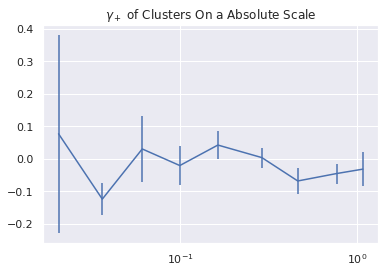

Aggregated xi:
[ 0.     -0.7746  2.1013 -0.3072  0.7715 -3.3786 -0.6207 11.387   9.9791
  2.1002]
------------------------------------------------------------------------------
Aggregated meanlogr:
[   0.      -38.8168  -56.3142  -27.9329  -87.5811 -142.957  -184.4559
 -129.4932  -59.1027    5.1134]
------------------------------------------------------------------------------
Aggregated npairs:
[  0.  10.  17.  10.  38.  79. 149. 168. 222.  67.]
------------------------------------------------------------------------------
Mean xi:
[    nan -0.0775  0.1236 -0.0307  0.0203 -0.0428 -0.0042  0.0678  0.045
  0.0313]
------------------------------------------------------------------------------
Mean meanlogr:
[    nan -3.8817 -3.3126 -2.7933 -2.3048 -1.8096 -1.238  -0.7708 -0.2662
  0.0763]
------------------------------------------------------------------------------


In [30]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

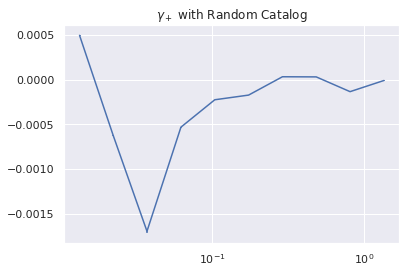

[ 4.9332e-04 -6.2438e-04 -1.6901e-03 -5.3002e-04 -2.2471e-04 -1.7261e-04
  3.1751e-05  3.0225e-05 -1.3427e-04 -1.0015e-05]
[-4.4173e-06  5.5909e-06  1.5134e-05  4.7459e-06  2.0121e-06  1.5456e-06
 -2.8431e-07 -2.7065e-07  1.2023e-06  8.9676e-08]


In [31]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

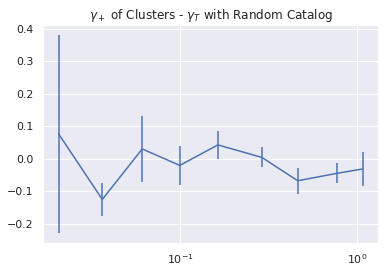

In [32]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

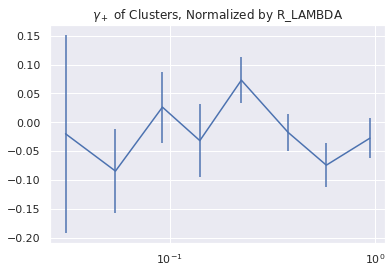

Aggregated xi:
[ 0.      0.      0.3161  1.0964 -0.3958  1.2317 -6.2845  2.2429 12.5217
  5.2524]
------------------------------------------------------------------------------
Aggregated meanlogr:
[   0.        0.      -55.5063  -37.8255  -35.7488  -76.5969 -128.885
 -126.7826  -92.2926  -11.0942]
------------------------------------------------------------------------------
Aggregated npairs:
[  0.   0.  16.  13.  15.  39.  86. 130. 169. 192.]
------------------------------------------------------------------------------
Mean xi:
[    nan     nan  0.0198  0.0843 -0.0264  0.0316 -0.0731  0.0173  0.0741
  0.0274]
------------------------------------------------------------------------------
Mean meanlogr:
[    nan     nan -3.4691 -2.9097 -2.3833 -1.964  -1.4987 -0.9753 -0.5461
 -0.0578]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [33]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)